В данном разделе рассмотрим подготовку данных и запуск обучения

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from PIL  import Image

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
from dotenv import load_dotenv
import warnings
load_dotenv()

warnings.filterwarnings('ignore')

Импортируем пути к матрицам ```(.npz)``` и изображениям ```(.jpeg)```

In [53]:
ECG_IMAGES_PATH = os.environ['ECG_IMAGES_PATH']
ECG_MATRCIES_PATH = os.environ['ECG_MATRICES_PATH']

REO_IMAGES_PATH = os.environ['REO_IMAGES_PATH']
REO_MATRCIES_PATH = os.environ['REO_MATRICES_PATH']

Далее необходимо написать класс ```Dataset```

In [54]:
class EcgReoDataset(Dataset):
	'''Класс датасета для подачи изображений в сеть'''
	def __init__(self, 
				ecg_folder_path,
				reo_folder_path,
				use_matrices = True):
		
		self.ecg_folder_path = ecg_folder_path
		self.reo_folder_path = reo_folder_path

		self.image_transform = transforms.Compose([
			transforms.ToTensor(),
			transforms.Normalize(mean=[0.5], std=[0.5])  
		])
		
		self.use_matrices = use_matrices
		self.ending = '.npz' if self.use_matrices else '.jpeg'

		ecg_files = [os.path.join(ecg_folder_path, f) 
					for f in os.listdir(ecg_folder_path) 
					if f.endswith(self.ending)]
		
		reo_files = [os.path.join(reo_folder_path, f) 
					for f in os.listdir(reo_folder_path) 
					if f.endswith(self.ending)]
		
		self.all_files = ecg_files + reo_files

		if not self.all_files:
			raise FileNotFoundError(f"No {self.ending} files found in the folders")
		
	def __len__(self):
		return len(self.all_files)
	
	def __getitem__(self, index):
		filepath = self.all_files[index]
		
		filename = os.path.basename(filepath)
		try:
			label = int(filename.split('_')[-1].split('.')[0])
		except:
			raise ValueError(f"Can't extract label from filename: {filename}")
		
		if self.use_matrices:
			data = np.load(filepath)['spec'] 
			tensor = torch.from_numpy(data).float()
			if len(tensor.shape) == 2:
				tensor = tensor.unsqueeze(0)
		else:
			img = Image.open(filepath).convert('L')
			tensor = self.image_transform(img)
		
		return {
			'data': tensor,
			'label': torch.tensor(label, dtype=torch.long),
			'filename': filename
		}

# Для Triplet Loss
class TripletEcgReoDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels_to_indices = self._create_labels_to_indices()
        self.labels = list(self.labels_to_indices.keys())
        
    def _create_labels_to_indices(self):
        labels_to_indices = {}
        for idx in range(len(self.base_dataset)):
            if isinstance(self.base_dataset, torch.utils.data.Subset):
                label = self.base_dataset.dataset[self.base_dataset.indices[idx]]['label'].item()
            else:
                label = self.base_dataset[idx]['label'].item()
            
            if label not in labels_to_indices:
                labels_to_indices[label] = []
            labels_to_indices[label].append(idx)
        return labels_to_indices
        
    def __getitem__(self, index):
        if isinstance(self.base_dataset, torch.utils.data.Subset):
            anchor_item = self.base_dataset.dataset[self.base_dataset.indices[index]]
        else:
            anchor_item = self.base_dataset[index]
        
        anchor_label = anchor_item['label'].item()
        
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.labels_to_indices[anchor_label])
        
        if isinstance(self.base_dataset, torch.utils.data.Subset):
            positive_item = self.base_dataset.dataset[self.base_dataset.indices[positive_index]]
        else:
            positive_item = self.base_dataset[positive_index]
        
        negative_label = random.choice([l for l in self.labels if l != anchor_label])
        negative_index = random.choice(self.labels_to_indices[negative_label])
        
        if isinstance(self.base_dataset, torch.utils.data.Subset):
            negative_item = self.base_dataset.dataset[self.base_dataset.indices[negative_index]]
        else:
            negative_item = self.base_dataset[negative_index]
        
        return (
            anchor_item['data'], 
            positive_item['data'], 
            negative_item['data']
        )
        
    def __len__(self):
        return len(self.base_dataset)
		

Пробуем получить данные из датасета

In [55]:
signals_dataset = EcgReoDataset(
    ecg_folder_path=ECG_IMAGES_PATH,
    reo_folder_path=REO_IMAGES_PATH,
    use_matrices=False
)

print(len(signals_dataset))

1332


Пробуем получить элемент датасета

In [56]:
len(signals_dataset[0])

3

Для подачи изображений датасет работает


Проверим для подачи матриц:

In [57]:
signals_dataset_matrices = EcgReoDataset(
    ecg_folder_path=ECG_MATRCIES_PATH,
    reo_folder_path=REO_MATRCIES_PATH,
    use_matrices=True
)

len(signals_dataset_matrices)

1332

In [58]:
signals_dataset_matrices[2]

{'data': tensor([[[7.3866e-05, 2.5242e-02, 9.2314e-04,  ..., 3.3340e-04,
           8.1578e-04, 2.2453e-02],
          [4.1124e-05, 3.6272e-02, 3.5738e-02,  ..., 1.3024e-02,
           3.1727e-02, 3.2149e-02],
          [1.0319e-04, 7.0313e-02, 4.2584e-03,  ..., 3.8854e-02,
           3.9619e-03, 6.2364e-02],
          ...,
          [8.0278e-04, 2.3583e-03, 2.9933e-03,  ..., 5.1613e-02,
           5.1636e-02, 5.9232e-02],
          [4.6262e-03, 2.9400e-03, 1.5006e-03,  ..., 5.0648e-02,
           5.1041e-02, 5.1205e-02],
          [5.3817e-03, 3.3158e-03, 1.5862e-03,  ..., 5.1070e-02,
           5.1741e-02, 5.2015e-02]]]),
 'label': tensor(0),
 'filename': 'ecg_window_8_2_0.npz'}

Для матриц

In [59]:
len(signals_dataset_matrices[0])

3

Датасеты корректно подготавливают данные

Посмотрим на тензор

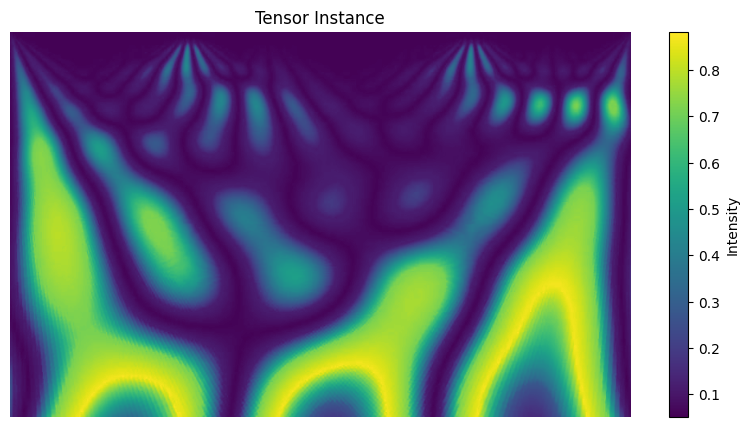

In [60]:
def plot_tensor(tensor):
	"""
	Визуализирует torch тензор.

	:param tensor: Torch тензор для визуализации.
	:param title: Заголовок графика.
	:param xlabel: Метка оси X.
	:param ylabel: Метка оси Y.
	"""
	if tensor.dim() == 3:
		tensor = np.transpose(tensor, (1, 2, 0))
		tensor = (tensor + 1) / 2.0
	elif tensor.dim() == 1:
		tensor = tensor.squeeze(0)
	else:
		pass

	plt.figure(figsize=(10, 5))
	plt.imshow(tensor, aspect='auto', cmap='viridis')
	plt.colorbar(label='Intensity')
	plt.title('Tensor Instance')
	plt.axis('off')
	plt.show()
	
plot_tensor(signals_dataset[2]['data'])

Далее необходимо подготовить модель к обучению на основе ```Constrastive Loss``` и ```Metric Learning```

Будем использовать фреймворк ```PyTorch Lightning``` 

In [61]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        losses = F.relu(pos_dist - neg_dist + self.margin)
        return losses.mean()

class CNNEmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        
        self.projection = nn.Sequential(
            nn.Linear(128, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        
    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
            
        features = self.encoder(x)
        return self.projection(features)


Пробуем вызвать ```forward call``` для наших изображений

In [62]:
x = signals_dataset[0]['data']
x.shape

torch.Size([1, 462, 775])

In [63]:
model_cnn = CNNEmbeddingNet().eval()
result = model_cnn(x)
result.size()

torch.Size([1, 128])

```Forward call``` корректно работает

Класс для ```Metric Learning```

In [64]:
class ImageMetricLearner(pl.LightningModule):
    def __init__(self, embedding_dim=128, lr=1e-3, margin=1.0):
        super().__init__()
        self.save_hyperparameters()
        self.embedding_net = CNNEmbeddingNet(embedding_dim)
        self.loss_fn = TripletLoss(margin=margin)
        self.lr = lr
        
    def forward(self, x):
        return self.embedding_net(x)
        
    def training_step(self, batch, batch_idx):
        anchor, positive, negative = batch
        anchor_embed = self(anchor)
        positive_embed = self(positive)
        negative_embed = self(negative)
        
        loss = self.loss_fn(anchor_embed, positive_embed, negative_embed)
        self.log('train_loss', loss, prog_bar=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        anchor, positive, negative = batch
        anchor_embed = self(anchor)
        positive_embed = self(positive)
        negative_embed = self(negative)
        
        loss = self.loss_fn(anchor_embed, positive_embed, negative_embed)
        self.log('val_loss', loss, prog_bar=True)
        return loss
        
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=3, factor=0.1)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

Делаем сплит данных:

In [13]:
train_size = int(0.8 * len(signals_dataset_matrices))
val_size = len(signals_dataset) - train_size
train_dataset, val_dataset = random_split(signals_dataset_matrices, [train_size, val_size])

train_triplet_dataset = TripletEcgReoDataset(train_dataset)
val_triplet_dataset = TripletEcgReoDataset(val_dataset)

print(len(train_triplet_dataset))
print(len(val_triplet_dataset))


1065
267


Создаем даталоадеры

In [14]:
batch_size = 16

train_loader = DataLoader(
    train_triplet_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_triplet_dataset,
    batch_size=batch_size,
    shuffle=False,
)

Конфигурируем обучение

In [15]:
model = ImageMetricLearner(
    embedding_dim=128,
    lr=1e-5,
    margin=1.0
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='best-model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

logger = TensorBoardLogger("tb_logs", name="ecg_reo_metric_learning")

trainer = Trainer(
    max_epochs=100,
    accelerator='auto',  
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=10,
    check_val_every_n_epoch=1
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Прробуем запуститься

In [16]:
trainer.fit(model, train_loader, val_loader)


  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | embedding_net | CNNEmbeddingNet | 114 K  | train
1 | loss_fn       | TripletLoss     | 0      | train
----------------------------------------------------------
114 K     Trainable params
0         Non-trainable params
114 K     Total params
0.458     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [66]:
model = ImageMetricLearner.load_from_checkpoint("/Users/chervonikov_alexey/Desktop/bmstu_final/diploma/notebooks/checkpoints/best-model-epoch=20-val_loss=1.01.ckpt")
model.eval()

ImageMetricLearner(
  (embedding_net): CNNEmbeddingNet(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): AdaptiveAvgPool2d(output_size=(1, 1))
      (13): Flatten(start_dim=1, end_dim=-1)
    )
    (projection): Sequential(
      (0): Linear(in_features=128, out_

Получение Эмбеддингов

In [67]:
from tqdm.auto import tqdm

def extract_embeddings_with_filenames(model, dataset, batch_size=32):
    """
    Извлекает эмбеддинги и сохраняет соответствие с именами файлов
    Args:
        model: обученная модель
        dataset: исходный датасет EcgReoDataset
        batch_size: размер батча для обработки
    Returns:
        DataFrame с колонками: filename, label, embedding (и сами эмбеддинги)
    """
    model.eval()
    device = next(model.parameters()).device
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    all_embeddings = []
    all_filenames = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader):
            data = batch['data'].to(device)
            embeddings = model(data)
            
            all_embeddings.append(embeddings.cpu().numpy())
            all_filenames.extend(batch['filename'])
            all_labels.extend(batch['label'].cpu().numpy())
    
    embeddings_array = np.vstack(all_embeddings)
    labels_array = np.array(all_labels)
    
    results_df = pd.DataFrame({
        'filename': all_filenames,
        'label': labels_array
    })
    
    for i in range(embeddings_array.shape[1]):
        results_df[f'embedding_{i}'] = embeddings_array[:, i]
    
    return results_df, embeddings_array

result_df, embeddings_array = extract_embeddings_with_filenames(model, signals_dataset_matrices)

  0%|          | 0/42 [00:00<?, ?it/s]

In [68]:
result_df.to_csv('../ecg_data/embeddings_with_filenames_upd.csv')

Проверим близость

In [69]:
from sklearn.neighbors import NearestNeighbors

embeddings_df = pd.read_csv("../ecg_data/embeddings_with_filenames_upd.csv")

ecg_df = embeddings_df[embeddings_df['filename'].str.contains('ecg', case=False)]
reo_df = embeddings_df[embeddings_df['filename'].str.contains('reo', case=False)]

ecg_embeddings = np.array([ecg_df[f'embedding_{i}'] for i in range(128)]).T  
reo_embeddings = np.array([reo_df[f'embedding_{i}'] for i in range(128)]).T

nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(reo_embeddings)

model = ImageMetricLearner.load_from_checkpoint("/Users/chervonikov_alexey/Desktop/bmstu_final/diploma/notebooks/checkpoints/best-model-epoch=20-val_loss=1.01.ckpt")

def find_closest_reo(ecg_filename, ecg_df, nbrs, reo_df):
    """Находит ближайшее REO изображение для заданного ECG"""
    ecg_idx = ecg_df[ecg_df['filename'] == ecg_filename].index[0]
    
    ecg_embedding = ecg_embeddings[ecg_idx].reshape(1, -1)
    
    distances, indices = nbrs.kneighbors(ecg_embedding)
    
    closest_reo = reo_df.iloc[indices[0][0]]
    
    return {
        'ecg_filename': ecg_filename,
        'reo_filename': closest_reo['filename'],
        'reo_label': closest_reo['label'],
        'distance': distances[0][0]
    }

Процессинг

In [70]:
def get_ecg_embedding(ecg_tensor, model, device=None):
    """Получает эмбеддинг для ECG тензора"""
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    with torch.no_grad():
        if len(ecg_tensor.shape) == 3:  
            ecg_tensor = ecg_tensor.unsqueeze(0)
        ecg_embedding = model(ecg_tensor.to(device)).cpu().numpy()
    
    return ecg_embedding.squeeze()

def find_closest_reo_in_df(ecg_embedding, full_df):
    """
    Ищет ближайшее REO изображение в датафрейме по эмбеддингу ECG
    
    Args:
        ecg_embedding: эмбеддинг ECG изображения (np.array)
        full_df: датафрейм со всеми эмбеддингами (содержит колонки:
                 'filename', 'label', 'embedding_0'...'embedding_N')
    
    Returns:
        Словарь с информацией о ближайшем REO изображении
    """
    reo_df = full_df[full_df['filename'].str.contains('reo', case=False)].copy()
    
    embedding_cols = [c for c in reo_df.columns if c.startswith('embedding_')]
    reo_embeddings = reo_df[embedding_cols].values
    
    nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(reo_embeddings)
    
    distances, indices = nbrs.kneighbors(ecg_embedding.reshape(1, -1))
    
    closest_reo = reo_df.iloc[indices[0][0]]
    
    return {
        'reo_filename': closest_reo['filename'],
        'reo_label': closest_reo['label'],
        'distance': float(distances[0][0]),
        'reo_embedding': reo_embeddings[indices[0][0]]
    }

def process_ecg_to_reo(ecg_tensor, model, full_df, device=None):
    """
    Полный цикл обработки ECG тензора до поиска ближайшего REO
    
    Args:
        ecg_tensor: тензор ECG изображения
        model: обученная модель
        full_df: датафрейм со всеми эмбеддингами
        device: устройство для вычислений (cuda/cpu)
    
    Returns:
        Словарь с результатами
    """
    ecg_embedding = get_ecg_embedding(ecg_tensor, model, device)
    result = find_closest_reo_in_df(ecg_embedding, full_df)
    result['ecg_embedding'] = ecg_embedding
    return result

Инференс

In [71]:
result = process_ecg_to_reo(signals_dataset_matrices[2]['data'], model, embeddings_df)

print(f"Ближайшее REO изображение: {result['reo_filename']}")
print(f"Метка REO: {result['reo_label']}")
print(f"Расстояние между эмбеддингами: {result['distance']:.4f}")

Ближайшее REO изображение: reo_window_112_0_0.npz
Метка REO: 0
Расстояние между эмбеддингами: 11.7828


Инференс работает

Прогоним все данные для подсчета общих метрик

In [73]:
def evaluate_ecg_reo_matches(model, signals_dataset, embeddings_df):
    """
    Оценивает качество сопоставления всех ECG изображений с соответствующими REO
    Args:
        model: обученная модель
        signals_dataset: датасет с ECG изображениями
        embeddings_df: датафрейм со всеми эмбеддингами
    Returns:
        Словарь с метриками и полными результатами
    """
    all_results = []
    true_labels = []
    pred_labels = []
    distances = []
    
    for i in tqdm(range(len(signals_dataset))):
        item = signals_dataset[i]
        ecg_tensor = item['data']
        true_label = item['label'].item()
        filename = item['filename']
        
        result = process_ecg_to_reo(ecg_tensor, model, embeddings_df)
        
        result['ecg_filename'] = filename
        result['true_label'] = true_label
        all_results.append(result)
        
        true_labels.append(true_label)
        pred_labels.append(result['reo_label'])
        distances.append(result['distance'])
    
    accuracy = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, output_dict=True)
    cm = confusion_matrix(true_labels, pred_labels)
    
    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'mean_distance': np.mean(distances),
        'results_df': pd.DataFrame(all_results),
        'all_results': all_results
    }


metrics = evaluate_ecg_reo_matches(model, signals_dataset_matrices, embeddings_df)

  0%|          | 0/1332 [00:00<?, ?it/s]

Посмотрим на метрики

In [74]:
metrics['mean_distance']

5.838262153655988

In [75]:
metrics['accuracy']

0.8183183183183184

В целом, точность классификации вполне себе)